In [ ]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


In [1]:
import pandas as pd
import numpy as np
# from rdkit import Chem
# from rdkit.Chem import MACCSkeys, Draw
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
# libraries neural network
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

In [2]:
maccs_df = pd.read_csv('EGFR_bioactivity_maccs.csv')

In [3]:
maccs_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,pIC50
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,1,1,1,0,0,0,1,1,1,0,0,1,0,1,0,1,0,1,1,1,1,1,1,0,7.387216
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,1,1,0,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,0,6.769551
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,1,0,1,0,1,1,1,1,0,1,0,5.031517
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,1,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,3.301030
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,0,2.522879


In [29]:
maccs_df = maccs_df.drop(columns=['Unnamed: 0'])

In [30]:
maccs_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,pIC50
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,1,1,1,0,0,0,1,1,1,0,0,1,0,1,0,1,0,1,1,1,1,1,1,0,7.387216
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,1,1,0,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,0,6.769551
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,1,0,1,0,1,1,1,1,0,1,0,5.031517
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,1,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,3.301030
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,0,2.522879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8538,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,1,0,1,0,1,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,4.698970
8539,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,1,0,0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,1,1,1,0,1,1,1,1,1,0,5.338187
8540,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,6.000000
8541,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,1,1,1,1,0,0,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,6.000000


In [49]:
# separate the inputs keys fp and the output pic50
X = maccs_df.iloc[:, maccs_df.columns != 'pIC50']
y = maccs_df.iloc[:, -1]

In [50]:
# separate the macc_keys, pic50 to training set and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [51]:
X_train.shape

(6834, 167)

In [52]:
y_train.shape

(6834,)

In [53]:
def NN_model(hidden1, hidden2):
    """
    creating neural network from two hidden layer
    using relu as activation function in two hidden layer
    and linear in the output layer

    parameters
    ----------
    hidden1 : Int
              number of neuons in first hidden layer

    hidden2: Int
             number of neuons in second hidden layer
    Returns
    --------
    model fully connected neural network model with two hidden layer
    """

    model = Sequential()
    # first hidden layer
    model.add(Dense(hidden1, activation='relu', name="layer1"))
    # dropout prevent overfitting
    Dropout(.5)
    # second headden layer
    model.add(Dense(hidden2, activation='relu', name="layer2"))
    Dropout(.5)
    # output layer
    model.add(Dense(1, activation='linear', name="layer3"))

    # compile model

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
    return model

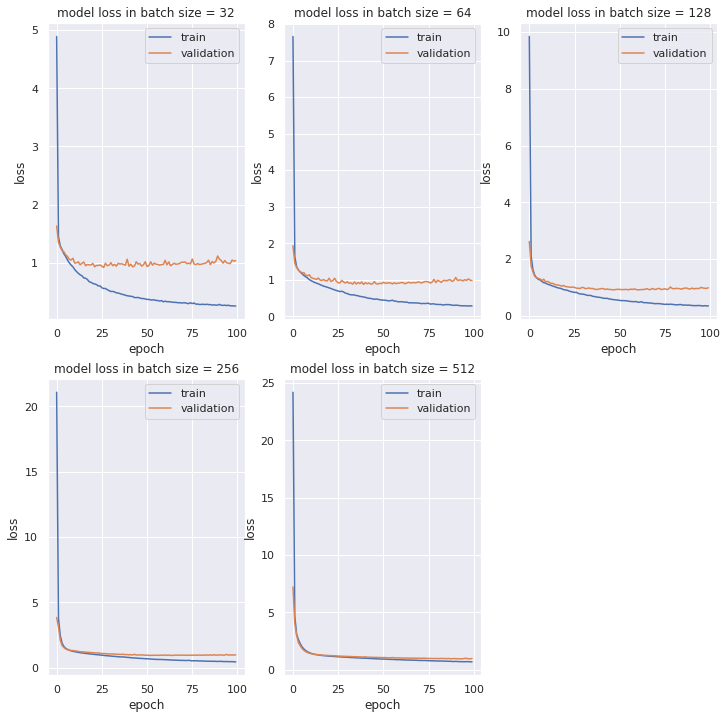

In [54]:
# trying different batch sizes

batch_sizes = [32, 64, 128, 256, 512]
# size of figure
fig = plt.figure(figsize=(12, 12))
sns.set(color_codes=True)
for i in range(1, 6):

    fig.add_subplot(2, 3, i)
    # creat new model
    model = NN_model(64, 32)
    history = model.fit(X_train, y_train, batch_size=batch_sizes[i-1],
                        validation_data=(X_test, y_test),
                        verbose=0, epochs=100)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('model loss in batch size = '+str(batch_sizes[i-1]))
plt.show()

In [63]:
x = X.values
Y = y

kf = KFold(5, shuffle=True, random_state=42)  # split the data to 5 fold

MSE = []  # empty list to add mean square error to all 5 folds

for j, (train, test) in enumerate(kf.split(X)):

    print(f"Fold #{j+1}")

    x_train = x[train]  # macc_keys for training
    Y_train = Y[train]  # pic50 for training
    x_test = x[test]    # macc_keys for testing
    Y_test = Y[test]    # pic50 for tsting

    model = NN_model(64, 32)

    model.fit(x_train, Y_train, batch_size=512, verbose=0, epochs=100)

    pred = model.predict(x_test)

    score = metrics.mean_squared_error(pred, Y_test)

    print(f"MSE score for fold{j+1}: {score}")

    MSE.append(score)

# MSE for all 5 fold
print('=================================================')
print(f'all MSE for 5 CV:{MSE}')

std_all_MSE = np.std(MSE)
mean_all_MSE = np.mean(MSE)

print("================================================")

print(f"mean:{mean_all_MSE}")
print(f"standard deviation:{std_all_MSE}")

Fold #1
MSE score for fold1: 0.9808409685945785
Fold #2
MSE score for fold2: 0.9714117871825121
Fold #3
MSE score for fold3: 0.9424055633754274
Fold #4
MSE score for fold4: 0.953898042160953
Fold #5
MSE score for fold5: 1.0290025258662936
all MSE for 5 CV:[0.9808409685945785, 0.9714117871825121, 0.9424055633754274, 0.953898042160953, 1.0290025258662936]
mean:0.975511777435953
standard deviation:0.029898646551576858


In [64]:
X_train.shape

(6834, 167)

In [65]:
y_train.shape

(6834,)


Epoch 00001: loss improved from inf to 25.36863, saving model to weights_CV.best.hdf5

Epoch 00002: loss improved from 25.36863 to 4.41246, saving model to weights_CV.best.hdf5

Epoch 00003: loss improved from 4.41246 to 3.31672, saving model to weights_CV.best.hdf5

Epoch 00004: loss improved from 3.31672 to 2.73304, saving model to weights_CV.best.hdf5

Epoch 00005: loss improved from 2.73304 to 2.35400, saving model to weights_CV.best.hdf5

Epoch 00006: loss improved from 2.35400 to 2.11797, saving model to weights_CV.best.hdf5

Epoch 00007: loss improved from 2.11797 to 1.95104, saving model to weights_CV.best.hdf5

Epoch 00008: loss improved from 1.95104 to 1.83319, saving model to weights_CV.best.hdf5

Epoch 00009: loss improved from 1.83319 to 1.72854, saving model to weights_CV.best.hdf5

Epoch 00010: loss improved from 1.72854 to 1.63157, saving model to weights_CV.best.hdf5

Epoch 00011: loss improved from 1.63157 to 1.54247, saving model to weights_CV.best.hdf5

Epoch 00012

Text(0.5, 1.0, 'Regression of prdicted keys with the model and original pic50 ')

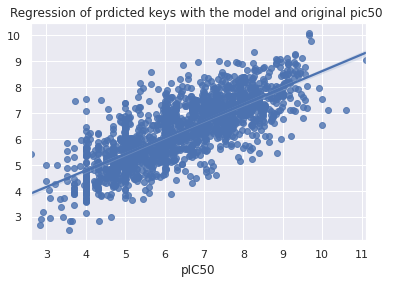

In [66]:
model = NN_model(64, 32)

# save the model
filepath = "weights_CV.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,
                             save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model.fit(X_train, y_train, epochs=100, batch_size=512,
          callbacks=callbacks_list, verbose=0)

score = model.evaluate(X_train, y_train)
print(f'score:{score}')

# predict all data
pred = model.predict(X_test)

# ploting to distribution of training data around the model
sns.set(color_codes=True)
ax = sns.regplot(x=y_test, y=pred)
ax.set_title('Regression of prdicted keys with the model and original pic50 ')

In [67]:
predicted_classes = model.predict(X_test)

In [68]:
predicted_value = predicted_classes

In [109]:
a = pd.DataFrame(predicted_value)
b = pd.DataFrame(y_test).reset_index()
b = b.drop(['index'], axis =1)

In [110]:
result = pd.concat([a,b], axis= 1)
result.columns=["Predicted","Test"]
result

,Predicted,Test
0,8.169868,6.160522
1,5.946932,7.004365
2,5.415979,2.602060
3,5.918733,5.300000
4,6.714447,6.352617
...,...,...
1704,5.394581,5.468521
1705,7.281572,7.853872
1706,6.281961,6.000000
1707,4.961014,4.904831


In [111]:
## loading and Testing the model on EGFR_test_set.csv

In [119]:
maccs_test_df = pd.read_csv('maccs_test.csv')

In [124]:
maccs_test_df = maccs_test_df.drop(columns = ['Unnamed: 0'])

In [126]:
predicted_pic50 = model.predict(maccs_test_df)

In [137]:
model

In [127]:
predicted_pic50 = pd.DataFrame(predicted_pic50, columns=['T04_predictions'])
predicted_pic50_df = test_df.join(predicted_pic50)

predicted_pic50_df.head(3)

,id,canonical_smiles,T04_predictions
0,1,S(Cc1c([O-])c(OC)cc(/C=C(\C#N)/C(=O)N)c1)c1ccccc1,6.105843
1,2,S=C(N)N1C(c2ccc(OC)cc2)CC(c2cc(C)c(C)cc2)=N1,6.333205
2,3,Clc1c(O)cc(-c2nn(C(C)C)c3ncnc(N)c23)cc1,5.792202


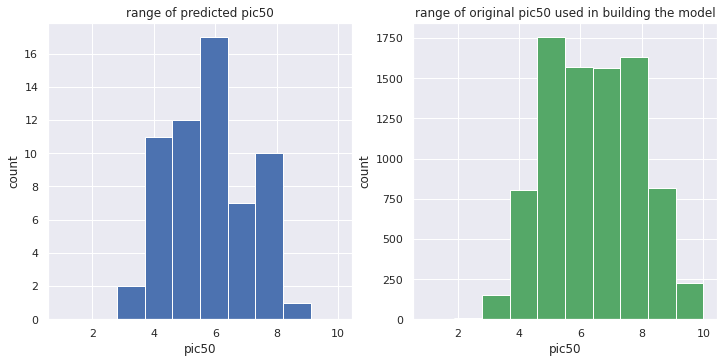

In [129]:
# Histogram to the distribution of the predected pic50 in test file
plt.figure(figsize=(12, 12))
sns.set(color_codes=True)

plt.subplot(221)
plt.hist(predicted_pic50_df["T04_predictions"],
         facecolor='b', histtype='barstacked', range=(1, 10))
plt.xlabel('pic50')
plt.ylabel('count')
plt.title('range of predicted pic50')

plt.subplot(222)
plt.hist(maccs_df["pIC50"], facecolor='g', range=(1, 10), bins=10)
plt.xlabel('pic50')
plt.ylabel('count')
plt.title('range of original pic50 used in building the model')
plt.show()
sns.set()


In [130]:
predicted_pic50_df_top3 = predicted_pic50_df.nlargest(3, 'T04_predictions')
predicted_pic50_df_top3

,id,canonical_smiles,T04_predictions
17,18,O(C)c1cc([O-])c2C(=O)C=3[C@H](O)[C@@H](O)[C@](...,8.828130
8,9,O(CC)c1c(OCC)cc2ncnc(C#Cc3c(-c4ccccc4)cc[nH]3)...,8.105155
9,10,Brc1cc(Nc2ncnc3nc(NC)ccc23)ccc1,7.997930


In [133]:
pip install rdkit-pypi

     |████████████████████████████████| 18.6MB 1.3MB/s 


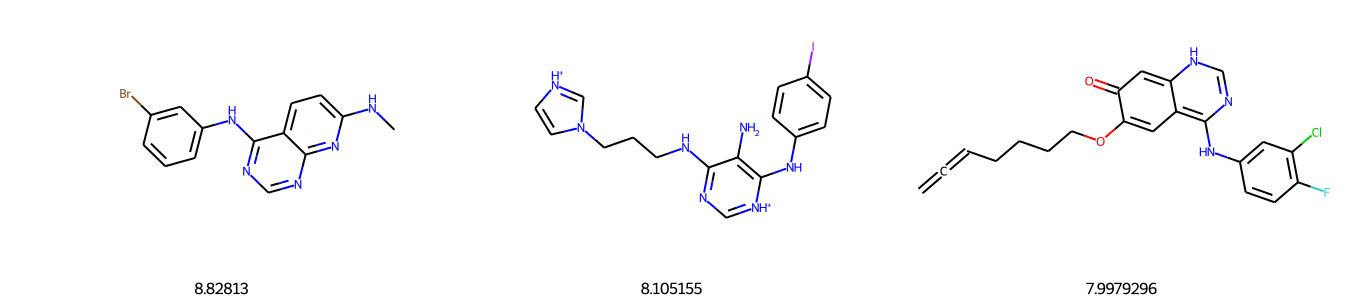

In [144]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw
# draw prdicted molecules to be good EGFR inhibitors drugs
highest_pic50 = predicted_pic50_df['canonical_smiles'][[9, 53, 18]]

mols_EGFR = [Chem.MolFromSmiles(smile) for smile in highest_pic50]
pic50_EGFR = predicted_pic50_df_top3['T04_predictions'].astype(str).tolist()

Draw.MolsToGridImage(mols_EGFR, molsPerRow=3, subImgSize=(450, 300), legends=pic50_EGFR)

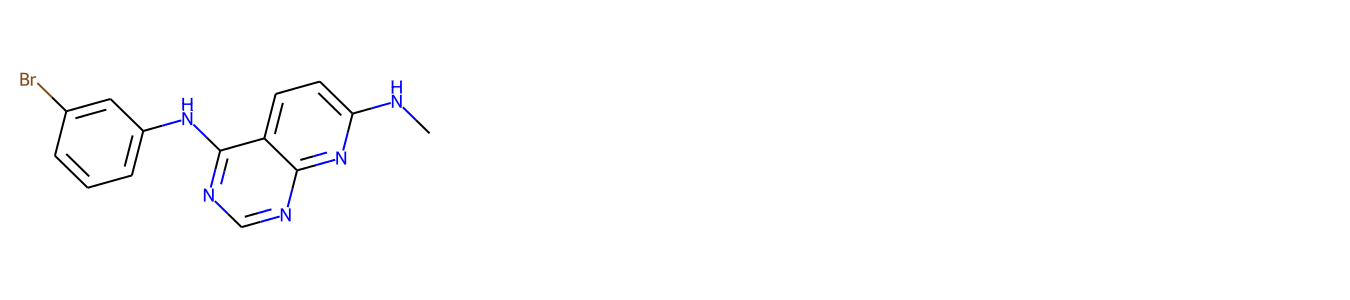

In [175]:
highest_pic50 = predicted_pic50_df['canonical_smiles'][[9]]

mols_EGFR = [Chem.MolFromSmiles(smile) for smile in highest_pic50]
# pic50_EGFR = predicted_pic50_df['T04_predictions'].astype(str).tolist()

Draw.MolsToGridImage(mols_EGFR, molsPerRow=3, subImgSize=(450, 300))

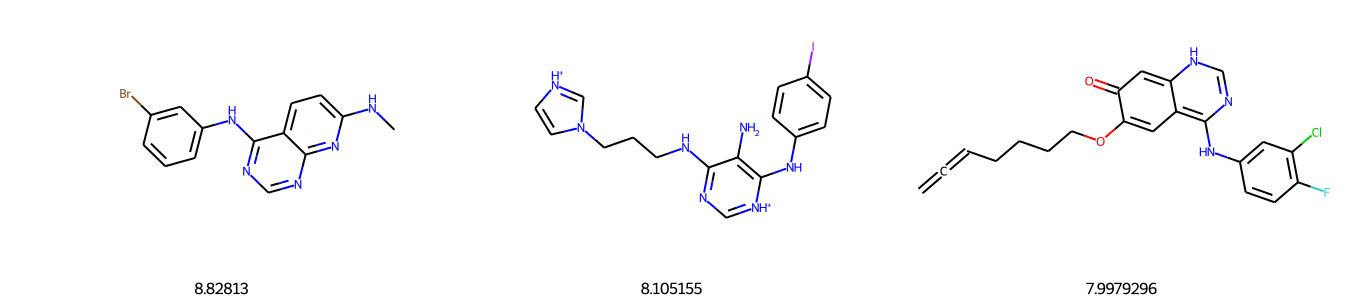

In [158]:
highest_pic50 = predicted_pic50_df['canonical_smiles'][[9, 53, 18]]

mols_EGFR = [Chem.MolFromSmiles(smile) for smile in highest_pic50]
pic50_EGFR = predicted_pic50_df_top3['T04_predictions'].astype(str).tolist()

Draw.MolsToGridImage(mols_EGFR, molsPerRow=3, subImgSize=(450, 300), legends=pic50_EGFR)

In [141]:
dmodel.save('NN_bioactivity_model.hdf5')